# Motivation

For a service provider, customer complaints may carry a negative connotation; however, we should look to complaints as **insights** for several reasons.

* They are often a good indicator of what is going wrong. They can highlight to management not only about challenges with people and processes, but also can provide ideas for new products and services.
* They provide an opportunity for the service provider to resolve the customer’s problems on time and thus reduce dissatisfaction levels.
* Customers who have had a problem resolved by a service provide effeciently, often have a stronger loyalty to the company compared with those that have *never* had a problem.

With the amount of unstructured text data that is currently on the internet - in forms of social media, product reviews, etc. This leaves businesses open to a wealth of data that they can process and then draw insights from. Text data is **notoriously** difficult to analyze; however, recent advances in **Natural Language Processing (NLP)** have made it easy for data scientist and software developers to build pipelines to achieve this task.

In this notebook, we will use NLP to automatically group consumer complaints into topics. These topics will enable us to discover and adapt to current and emerging trends and identify problem areas. By pinpointing and these types of issues, we can make recommendations to better deliver customer service experiences.

Crossposted at my blog here: https://horvay.dev/complaint-classifier/

# The Comcast Consumer Complaints Dataset

The [Comcast Consumer Complaints Dataset][comcast-dataset] is a public dataset compiled by [Charlie H.][charlie] on Kaggle. His motivative for uploading provides a description of the dataset: "Comcast is notorious for terrible customer service and despite repeated promises to improve, they continue to fall short. Only last month (October 2016) the FCC fined them a cool $2.3 million after receiving [over 1000 consumer complaints][complaints]. After dealing with their customer service for hours yesterday, I wanted to find out more about others' experiences."

The dataset consists of two CSV files. The first is [comcast_consumeraffairs_complaints.csv][consumeraffair-csv], which has four columns author, posted_on, rating, and text. The second is [comcast_fcc_complaints_2015.csv][fcc-csv], which has Ticket #, Customer Complaint, Date, Time, Received Via, City, State, Zip code, Status, Filing on Behalf of Someone, and Description.

The most interesting part of these two files are that they both contain verbatim text. Meaning we have the customer complaint iteself! We will leverage this for our analysis.

[comcast-dataset]:https://www.kaggle.com/archaeocharlie/comcastcomplaints
[charlie]:https://www.kaggle.com/archaeocharlie
[complaints]:money.cnn.com/2016/10/11/news/companies/comcast-fine-fcc/
[consumeraffair-csv]:https://raw.githubusercontent.com/dhorvay/consumer-complaint-classifier/master/comcastcomplaints/comcast_consumeraffairs_complaints.csv
[fcc-csv]:https://raw.githubusercontent.com/dhorvay/consumer-complaint-classifier/master/comcastcomplaints/comcast_fcc_complaints_2015.csv

# NLP - Machine Learning Flow

This explains the flow that we will be using for our Topic Modeling.

![alt text](https://horvay.dev/assets/images/2020-03-29-complaint-classifier/2020-03-29-nlp-flow.png "NLP Flow")

# Exploratory Data Analysis (EDA)

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import pickle
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, save
from bokeh.models import ColumnDataSource
from bokeh.transform import cumsum
from bokeh.io import curdoc
curdoc().theme = 'dark_minimal'

In [2]:
ca_df = pd.read_csv('/kaggle/input/comcastcomplaints/comcast_consumeraffairs_complaints.csv')
ca_df.head()

,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...


In [3]:
fcc_df = pd.read_csv('/kaggle/input/comcastcomplaints/comcast_fcc_complaints_2015.csv')
fcc_df.head()

,Ticket #,Customer Complaint,Date,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Description
0,250635,Comcast Cable Internet Speeds,4/22/2015,3:53:50 PM,Internet,Abingdon,Maryland,21009,Closed,No,I have been contacting Comcast Internet Techni...
1,223441,Payment disappear - service got disconnected,4/8/2015,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,Back in January 2015 I made 2 payments: One fo...
2,242732,Speed and Service,4/18/2015,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,Our home is located at in Acworth Georgia 3010...
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,5/7/2015,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,Comcast in the Atlanta area has just put into ...
4,307175,Comcast not working and no service to boot,5/26/2015,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No,I have been a customer of Comcast of some sort...


#### Let's give our charts the famous peacock colors

![alt text](https://horvay.dev/assets/images/2020-03-29-complaint-classifier/2020-03-29-peacock.png "Peacock Theme")

In [4]:
# Try to make it Comcast (new logo after NBC merge) themed
peacock_theme = ['#cc004c','#f37021','#fcb711','#6460aa','#0089d0','#0db14b','#ffc0cb','#00ffff']

# Customer Statisfaction (CSAT) Calculation

### What is Customer Satisfaction (CSAT)?

A metrics that measures short-term happiness, or how a customer feels about a specific service or product.

### How is CSAT measured?

On a scale of 0-5, how would you measure your satifaction with [Company]?

$$\dfrac {\text{# of Satisfied Customers}}{\text{# of Reviews}} \cdot 100= \text{% of Satisfied Customers}$$

A satisfied customer in the case of 0-5 would be any customer that would be greater than or equal to a score of 4.

<img src="https://horvay.dev/assets/images/2020-03-29-complaint-classifier/2020-03-29-csat.png" alt="Customer Satisfaction Score (CSAT)" style="width: 50%;"/>

In [5]:
# Calculate CSAT
csat = len(ca_df.loc[ca_df['rating']>=4])/len(ca_df)
print("Comcast's Customer Satisfaction Score calculated from ConsumerAffairs is {:.2f}%".format(csat*100))

Comcast's Customer Satisfaction Score calculated from ConsumerAffairs is 0.90%


#### Customer satisfaction score of 0.90% is really, really bad...

I think what we are seeing with the ConsumersAffairs dataset is a subset of customers who are generally unhappy with the services Comcast provides. I doubt that Comcast's *true* CSAT score is 0.90%; however, what this tells me is that many of the customers who are writing reviews are definately providing us insights on what is going wrong at Comcast. According to ASCI, [their score is 62][comcast-asci], I will take theirs as more accurate, but they use a different calculcation that what I have here.

[comcast-asci]:https://www.theacsi.org/?option=com_content&view=article&id=149&catid=&Itemid=214&c=Comcast&i=Subscription+Television+Service

Let's get a better visual on the ratings...

In [6]:
rating_df = pd.DataFrame({'class': ['0', '1', '2', '3', '4', '5'],
                          'percent' : ca_df['rating'].value_counts(normalize=True).sort_index()*100,
                          'angle': ca_df['rating'].value_counts(normalize=True).sort_index() * 2 * np.pi,
                          'color': peacock_theme[0:6]})
rating_df

,class,percent,angle,color
0,0,27.566708,1.732067,#cc004c
1,1,65.983389,4.145859,#f37021
2,2,4.594451,0.288678,#fcb711
3,3,0.954232,0.059956,#6460aa
4,4,0.335748,0.021096,#0089d0
5,5,0.565471,0.035530,#0db14b


In [7]:
rating_src = ColumnDataSource(rating_df)
# Date range of ratings
sorted_dates = ca_df['posted_on'].sort_values().reset_index(drop=True).tolist()
rating_plt_title = 'Comcast ConsumerAffairs Ratings {} - {}'.format(sorted_dates[0], sorted_dates[-1])

# Create the Figure object "rating_plt"
rating_plt = figure(title=rating_plt_title, tools=['save', 'hover'], tooltips='@percent{0.00}%')

# Add circular sectors to "rating_plt"
rating_plt.wedge(x=0, y=0, radius=0.8, source=rating_src, start_angle=cumsum('angle', include_zero=True),
                 end_angle=cumsum('angle'), fill_color='color', line_color=None, legend_field='class')

# Change parameters of "rating_plt"
rating_plt.axis.visible = False
rating_plt.grid.grid_line_color = None
rating_plt.legend.orientation = 'horizontal'
rating_plt.legend.location = 'top_center'
output_notebook()
show(rating_plt)

Loading BokehJS ...

# Time series analysis

In [8]:
ca_df['posted_on'] = pd.to_datetime(ca_df['posted_on'])

groupby_posted_on = ca_df.groupby('posted_on').count()

ts_src = ColumnDataSource(groupby_posted_on)

ts_plt_title = 'Number of reviews per day {} - {}'.format(sorted_dates[0], sorted_dates[-1])
ts_plt = figure(title=ts_plt_title, x_axis_type='datetime', tools=['save', 'hover'], tooltips=[('Count', '@rating')])

ts_plt.line(x='posted_on', y='rating', line_width=2, source=ts_src, color=peacock_theme[0])

ts_plt.yaxis.axis_label = 'Number of Reviews'

show(ts_plt)

## Outliers

Seems that there was a lot of activity on a certain date in 2016, with the number of reviews being over 50 - much more than the average, which is less than 10. Maybe there was some major outage around this time...can we find if anything unusual happened?

In [9]:
# What the hell happened?
groupby_posted_on.loc[groupby_posted_on['rating'] > 50]

# Change pandas settings to allow max rows be 100
ca_df.loc[ca_df['posted_on'] == '2016-02-24']

,author,posted_on,rating,text
179,"Joshua of Philadelphia, PA",2016-02-24,1,My modem is directly connected to my computer....
1817,"Pene of Las Vegas, NV",2016-02-24,3,The field technician was great. However it too...
1818,"Beverly of Chesterfield, VA",2016-02-24,3,Had issue getting voice mail but customer serv...
1819,"John of Berkeley, CA",2016-02-24,3,"They're generally curious, knowledgeable, and ..."
1820,"Yvonne of Mt. Juliet, TN",2016-02-24,2,It's so difficult to reach them. I usually had...
...,...,...,...,...
1875,"Cynthia of Canton, GA",2016-02-24,1,"Minimally, it takes five minutes before you re..."
1876,"peggy of Boulder, CO",2016-02-24,1,If one wants it... one has to actually head do...
1877,"V of Gibbstown, NJ",2016-02-24,2,I had extremely slow internet for YEARS and th...
1878,"Monica of Vallejo, CA",2016-02-24,2,It takes over 5 minutes of listening to a phon...


Even looking at the text, it doesn't seem that there is any unusual problem that sticks out for this day. This gives me some doubts about the dataset we have; however, there is always just a possibility that it is a legitimate outlier.

Let's layer the FCC Complaints on top of this.

In [10]:
fcc_df['Date'] = pd.to_datetime(fcc_df['Date'])

ca_df['Count'] = 0
ca_df2 = ca_df.loc[ca_df['posted_on'] >= '2015-01-01']
groupby_posted_on = ca_df2.groupby('posted_on').count()

ts_ca_src = ColumnDataSource(groupby_posted_on)

fcc_df['Count'] = 0
groupby_date = fcc_df.groupby('Date').count()

ts_fcc_src = ColumnDataSource(groupby_date)

ts_fcc_plt = figure(title="Number of Customer FCC Complaints and ConsumerAffairs Reviews Per Day",
                    x_axis_type='datetime', tools=['save', 'hover'], tooltips=[('Count', '@Count')])

ts_fcc_plt.line(x='Date', y='Customer Complaint', line_width=2, source=ts_fcc_src, color=peacock_theme[1],
                legend_label=' # of FCC Customer Complaints')

ts_fcc_plt.line(x='posted_on', y='rating', line_width=2, source=ts_ca_src, color=peacock_theme[0],
                legend_label='# of ConsumerAffairs Reviews')

show(ts_fcc_plt)

fcc_df = fcc_df.drop(columns="Count")

## Current complaint categories

Let's look at our current complaint categories (from now refered to as **topics**). This is what we will refine later when we implement our NLP algorithms.

In [11]:
fcc_df['Customer Complaint'].value_counts()

Comcast                                                                  83
Comcast Internet                                                         18
Comcast Data Cap                                                         17
comcast                                                                  13
Comcast Data Caps                                                        11
                                                                         ..
Unauthorized 2-Year Contract With Comcast                                 1
overcharged                                                               1
Comcast Charging Service Fee To Customer--Customer Didn't Cause Issue     1
Comcast billing error                                                     1
Lies and deception                                                        1
Name: Customer Complaint, Length: 1842, dtype: int64

According to customers, there are 1842 different topics, which we know is not the case. Can we use simple string manipulation to get a better grasp on what customers are complaining about?

In [12]:
def get_simple_topic_percentage(topic):
    """
    Returns a percentage of rows that this particular topic is found
    in using simple string manipulation. Note: this can have overlaps,
    for example if you have two topics, one 'Internet' and one 'Speed',
    you will get duplicate findings if the customer has 'Internet Speed'
    as their topic.
    
    topic: the customer complaint category entered by the customer.
    """
    return fcc_df[fcc_df['Customer Complaint'].str.contains(topic, case=False)].shape[0] / len(fcc_df['Customer Complaint']) * 100
    

print('Comcast:', get_simple_topic_percentage('comcast'))
print('Data cap:', get_simple_topic_percentage('data'))
print('Speed:', get_simple_topic_percentage('speed'))
print('Internet:', get_simple_topic_percentage('internet'))
print('Price:', get_simple_topic_percentage('price'))
print('Bill:', get_simple_topic_percentage('bill'))
print('Customer Service:', get_simple_topic_percentage('customer service'))

Comcast: 56.044943820224724
Data cap: 9.887640449438202
Speed: 8.629213483146067
Internet: 23.91011235955056
Price: 2.6516853932584272
Bill: 17.078651685393258
Customer Service: 3.50561797752809


# Preprocessing

We will use the [spaCy][spacy] library for preprocessing. This library is amazing and its tagline is 'industrial strength Natural Language Processing', which it definately lives up to. We can preprocess our complaints in just a few lines.

### Tokenization
Different languages will have different tokenization rules. Let's look at an example of how tokenization might work in English. For the sentence – 'It's nice out today.', it would be broken up as follows, with the appropriate numerical indices:

| 0  | 1  | 2    |  3  |   4   |
|----|----|------|-----|-------|
| It | is | nice | out | today |

This looks like the result when we run `.split(' ')` in Python – why do we give it a special name of tokening?

If you notice carefully, the sentence has been split differenly for example: **It's** into **It** *and* **is** and punctuation has been removed.

### Remove Stopwords

Stopwords are words which are filtered out before processing our data. Though "stopwords" usually refers to the most common words in a language (e.g for english, 'the', 'a', etc..) there is no single universal list of stopwords used by all natural language processing tools, and indeed not all tools even use such a list. Some tools specifically avoid removing these stopwords to support phrase search. 

### Lemmatization and stemming

Paraphrasing [Introduction to Information Retrieval by Christopher D. Manning, Prabhakar Raghavan and Hinrich Schütze][ir-retrieval]: "Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma."

[spacy]:https://spacy.io/
[ir-retrieval]: https://nlp.stanford.edu/IR-book

In [13]:
from spacy.lang.en import English
nlp = English()

customize_stop_words = ['comcast', 'i', 'fcc', 'hello', 'service', 'services', 'issue',
                        'issues', 'problem', 'problems', 'xfinity', 'customer', 'complaint', '$']
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

def preprocess(verbatim):
    """
    Tokenizes, removes stopwords, and lemmatizes a verbatim text
    
    verbatim: a free-form text complaint
    """
    # Every verbatim ends with the FCC follow up, let's remove this.
    verbatim = verbatim.split('\n')[0].lower()
    doc = nlp(verbatim)
    sent = []
    for word in doc:
        # If it's not a stop word or punctuation mark, add it to our article!
        if word.text != 'n' and not word.is_stop and not word.is_punct and not word.like_num:
            # We add the lematized version of the word
            sent.append(word.lemma_.lower())
    return sent

# Tokenize each complaint
docs = fcc_df['Description'].apply(lambda verbatim: preprocess(verbatim))

In [14]:
docs[0]

['contacting',
 'internet',
 'technical',
 'support',
 'months',
 'resolve',
 'slow',
 'internet',
 'speed',
 'permanent',
 'resolution',
 'sent',
 'techs',
 'residence',
 'replaced',
 'hardware']

### Revisiting categorization using NLTK

[('internet', 533), ('billing', 294), ('data', 220), ('speed', 121), ('cap', 106), ('caps', 79), ('practices', 73), ('speeds', 72), ('charges', 71), ('bill', 64), ('unfair', 59), ('cable', 56), ('throttling', 54), ('slow', 49), ('usage', 47), ('poor', 45), ('pricing', 42), ('price', 40), ('connection', 37), ('business', 33), ('contract', 30), ('phone', 30), ('false', 27), ('charged', 27), ('account', 26), ('charging', 25), ('high', 25), ('fees', 24), ('deceptive', 23), ('charge', 23)]


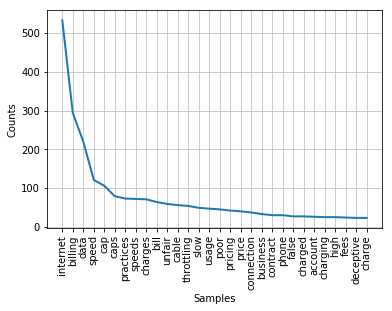

In [15]:
import nltk
from nltk import FreqDist
cats = fcc_df['Customer Complaint'].apply(lambda verbatim: preprocess(verbatim))
filtered_complaints = [c for cl in cats for c in cl]
fdist = FreqDist(filtered_complaints)
print(fdist.most_common(30))
fdist.plot(30)

# Latent Dirichlet Allocation (LDA)

For the purpose of this explaination I will be using terms interchangably, let's define those:

* **Topic** means the same as **Complaint Category**.
* **Document** means the same as a **Complaint Verbatim**.
* **Corpus** means the same as **all the Complaint Verbatims in the CSV**.

Latent Dirichlet Allocation (LDA) is a probabilistic model that assumes that every topic is a bag of words and every document is a bag of topics that each can be chosen with from the bag with some probability.

LDA is an unsupervised learning method. The number of topics, **k**, are left to us to determine and the *interpretation* of the topics is also left to us.

For example, let's say you have a complaint like - **"I was charged a late fee but I paid my bill on the 16th"**. With LDA, we will look at all the documents in our corpus and begin separting them into topics. After, for this particular document, we can say that this complaint is made up of two topics: it is 40% "Fees" and 60% "Payments". We can also say if we select a word at random from "Fees" we might get the word "charged " with a probability of 5.0% (just an example).

[Here](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/), you can find a very good write-up of it by [Edwin Chen](http://blog.echen.me).

*How LDA sees the complaints*
<img src="https://horvay.dev/assets/images/2020-03-29-complaint-classifier/2020-03-29-lda.png" alt="Latent Dirichlet Allocation (LDA)" style="width: 50%;"/>

In [16]:
import gensim
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)

print('Distinct words in initial documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 30% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.3)

print('Distinct words after removing rare and common words:', len(dictionary))

Distinct words in initial documents: 7250
Distinct words after removing rare and common words: 1149


Let's train and create the model:

In [17]:
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis.gensim

corpus = [dictionary.doc2bow(doc) for doc in docs]
num_topics = 8

# Check for .pickle
filename = '/kaggle/input/lda-modelpickle/lda_model.pickle'
model = []
found = False
try: 
    infile = open(filename,'rb')
    model = pickle.load(infile)
    infile.close()
    found = True
    print('Model found..loaded.')
except:
    print('Model not found!')

if not found:
    %time model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=20, workers=2)
    outfile = open(filename,'wb')
    pickle.dump(model, outfile)
    outfile.close()

Model found..loaded.


In [18]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary)

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.148846 -0.037759       1        1  25.113171
1     -0.022588 -0.121105       2        1  17.641588
6      0.064724  0.108680       3        1  14.722620
2      0.113276  0.143193       4        1  10.122167
7     -0.064744 -0.092511       5        1  10.084109
4     -0.176708 -0.025314       6        1   9.516596
0      0.278653 -0.127123       7        1   6.621765
5     -0.043768  0.151937       8        1   6.177987, topic_info=    Category        Freq   Term       Total  loglift  logprob
368  Default  439.000000   data  439.000000  30.0000  30.0000
99   Default  906.000000   bill  906.000000  29.0000  29.0000
9    Default  538.000000  speed  538.000000  28.0000  28.0000
84   Default  638.000000  cable  638.000000  27.0000  27.0000
60   Default  229.000000    cap  229.000000  26.0000  26.0000
..       ...         ...    ...         ...      ...      ...
160   Topic8   21.464594    day  285.669556   0.1957  -5.1615
195   Topic8   21.755198    new  448.885315  -0.2427  -5.1480
168   Topic8   19.869476   work  271.245483   0.1703  -5.2387
194   Topic8   19.927645  modem  484.645355  -0.4071  -5.2358
340   Topic8   19.518883    pay  546.721619  -0.5484  -5.2565

[505 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
563       1  0.888875     1st
563       4  0.093566     1st
617       3  0.752226  25mbps
617       8  0.188056  25mbps
564       1  0.913650     3rd
...     ...       ...     ...
65        4  0.083282   years
65        5  0.130128   years
65        6  0.145743   years
65        7  0.213410   years
65        8  0.046846   years

[1574 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 7, 3, 8, 5, 1, 6])

### Explaining the pyLDAvis output

The left panel displays the Intertopic Distance Map, which represents different topics and the distance between them. The closer the topics are in meaning the closer they appear, the same goes for dissimilar topics. The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus, which you can examine by hovering over the topic.

The right panel, displays a bar chart representing the 'salientcy' of words. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics. When no topic is selected in the plot on the left, the bar chart shows the top-30 most salient terms in the entire corpus, while selecting a topic on the left modifies the bar chart to show its relevent topics. Relevence is defined as in footer 2 and can be tuned by parameter λ, smaller λ gives higher weight to the term's distinctiveness while larger λ's corresponds to probablity of the term occurance per topics.

# Evaluating the model

When evaluating unsupervised learning techniques, we need to get a little creative. Most of the magic was done in the hyperparameter tuning we did previously - selecting **k**, etc.

One way we can evaluate is by splitting our dataset into two and comparing the topics found in each section. The more similar the topics found, the better.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

fcc_df_super = fcc_df.copy()

fcc_df_super['Tokens'] = docs

docs_upper = fcc_df_super['Tokens'].apply(lambda l: l[:int(len(l)/2)])
docs_lower = fcc_df_super['Tokens'].apply(lambda l: l[int(len(l)/2):])

Transform the data

In [20]:
corpus_upper = [dictionary.doc2bow(doc) for doc in docs_upper]
corpus_lower = [dictionary.doc2bow(doc) for doc in docs_lower]

# Using the corpus LDA model tranformation
lda_corpus_upper = model[corpus_upper]
lda_corpus_lower = model[corpus_lower]

In [21]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False): 
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    
    model: the LDA model
    corpus: the documents
    kwords: if True adds and returns the keys
    '''
    top_dist =[]
    keys = []
    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.asarray(vals)]
        if kwords:
            keys += [np.asarray(vals).argmax()]

    return np.asarray(top_dist), keys

### Cosine-similarity

We can use cosine similiarity to find how close the word are between the corresponding parts of a document - this is called **Intra-similarity** and a higher number is better. We can also find how close words are between random parts of a document - this is called **Inter-similarity** and a lower number is better.

In [22]:
top_dist_upper, _ = get_doc_topic_dist(model, lda_corpus_upper)
top_dist_lower, _ = get_doc_topic_dist(model, lda_corpus_lower)

print("Intra-similarity:", np.mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1, c2 in zip(top_dist_upper, top_dist_lower)]))

random_pairs = np.random.randint(0, len(fcc_df_super['Description']), size=(400, 2))

print("Inter-similarity:", np.mean([cosine_similarity(top_dist_upper[0].reshape(1, -1), top_dist_lower[1].reshape(1, -1))]))

Intra-similarity: 0.7216255
Inter-similarity: 0.34865516


### Labeling the Topics

We can now iterate through our model and find the 'Top N' words for each topic. Let's assign the topics labels finally.

In [23]:
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('\nTopic {}\n'.format(str(i)))
    for term, frequency in model.show_topic(i, topn=10):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

term                 frequency


Topic 0

cable                0.058
price                0.046
package              0.035
month                0.031
bill                 0.027
dollars              0.022
lower                0.016
increase             0.015
television           0.014
cost                 0.013

Topic 1

bill                 0.060
month                0.031
told                 0.023
account              0.023
billing              0.016
pay                  0.016
called               0.016
said                 0.015
credit               0.014
charges              0.013

Topic 2

data                 0.070
cap                  0.037
gb                   0.031
usage                0.027
month                0.023
limit                0.016
use                  0.016
caps                 0.014
area                 0.012
netflix              0.010

Topic 3

told                 0.025
called               0.024
time                 0.018
tech                 0.017
phone     

We can now assign labels for our topics by interpreting these top words and frequencies:
* Pricing
* Billing
* Data Caps
* Missed Appointments
* Moving Services
* Customer Services
* Internet Speed
* Business Contracts

In [24]:
top_labels = {0: 'Pricing', 1:'Billing', 2:'Data Caps', 3:'Missed Appointments', 4:'Moving Services', 5: 'Customer Services', 6:'Internet Speed', 7: 'Business Contracts'}

### tf-idf

tf-idf stands for "Term Frequency-Inverse Document Frequency". It is a numeric measure that is use to score the importance of a word in a document based on how often did it appear in that document and a given collection of documents. The intuition for this measure is : If a word appears frequently in a document, then it should be important and we should give that word a high score. But if a word appears in too many other documents, it’s probably not a unique identifier, therefore we should assign a lower score to that word. The math formula for this measure 

$$\mbox{tf-idf}_{t,d} = (1 +\log \mbox{tf}_{t,d}) \cdot \log \frac{N}{\mbox{df}_t}$$

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',
                                  tokenizer=preprocess, ngram_range=(1,3), min_df=40, max_df=0.20,
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

dtm = tvectorizer.fit_transform(fcc_df_super['Description']).toarray()

In [26]:
top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)
features = tvectorizer.get_feature_names()

In [27]:
top_words = []
for n in range(len(dtm)):
    inds = np.int0(np.argsort(dtm[n])[::-1][:4])
    top_words += [', '.join([features[i] for i in inds])]
    
fcc_df_super['Description Top Words'] = pd.DataFrame(top_words)
fcc_df_super['Topic'] = pd.DataFrame(lda_keys)
# Fill missing values with dummy
fcc_df_super['Topic'].fillna(-1, inplace=True)
fcc_df_super.head()

,Ticket #,Customer Complaint,Date,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Description,Tokens,Description Top Words,Topic
0,250635,Comcast Cable Internet Speeds,2015-04-22,3:53:50 PM,Internet,Abingdon,Maryland,21009,Closed,No,I have been contacting Comcast Internet Techni...,"[contacting, internet, technical, support, mon...","resolution, support, resolve, internet speed",4
1,223441,Payment disappear - service got disconnected,2015-04-08,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,Back in January 2015 I made 2 payments: One fo...,"[january, payments, january, february, advance...","payment, care, number, account",1
2,242732,Speed and Service,2015-04-18,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,Our home is located at in Acworth Georgia 3010...,"[home, located, acworth, georgia, signed, year...","high speed internet, billed, high speed, speed...",7
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,2015-05-07,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,Comcast in the Atlanta area has just put into ...,"[atlanta, area, effect, unprecendented, usage,...","gb, usage, cap, area",2
4,307175,Comcast not working and no service to boot,2015-05-26,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No,I have been a customer of Comcast of some sort...,"[sort, years, like]","years, like, gone, forced",6


# t-SNE Visualization

According to the author, [Laurens van der Maaten](https://lvdmaaten.github.io/tsne/), "t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets."

To simplify it, we can map our model onto a 2d space to give it a more human readable visualization.

This [notebook](https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization) by [Yasmin](https://www.kaggle.com/ykhorramz) helped me greatly during the new few cells.

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(top_dist)

fcc_df_super['Description Truncated'] = fcc_df_super['Description'].apply(lambda x: x[0:140])
fcc_df_super['X_tsne'] = X_tsne[:,0]
fcc_df_super['Y_tsne'] = X_tsne[:,1]

fcc_df_super['Colors'] = fcc_df_super['Topic'].apply(lambda topic_num: peacock_theme[topic_num])

source = ColumnDataSource(dict(
    x=fcc_df_super['X_tsne'],
    y=fcc_df_super['Y_tsne'],
    color=fcc_df_super['Colors'],
    label=fcc_df_super['Topic'].apply(lambda t: top_labels[t]),
    old_topic=fcc_df_super['Customer Complaint'],
    top_words=fcc_df_super['Description Top Words'],
    description=fcc_df_super['Description Truncated']))

Plotting t-SNE:

In [29]:
title = 'T-SNE Visualization of Topics'
plot_tsne = figure(plot_width=1000, plot_height=600, title=title,
                   tools=['pan', 'wheel_zoom', 'save', 'hover'], tooltips=[("Old Topic","@old_topic"),
                                                                           ("Description","@description"),
                                                                           ("Top Words","@top_words")])

plot_tsne.scatter(x='x', y='y', legend_field='label', source=source, color='color', alpha=0.6, size=5.0)
plot_tsne.legend.location = "top_right"

show(plot_tsne)

# Getting Insights

From this visualization we can see what our main problem areas from our topics. We have narrowed them down from 1000+ free-text user-entered to 8 LDA-generated. We are able to understand without having to go through one-by-one which each customer is complaining about. We can see some of the centrals themes such as "Billing", which affects every other topic, whereas something peripheral themes such as "Missed Appointments" might require its own strategy to resolve.

For further improvements, could we run something like sentiment analysis on this interactive graph to futher understand how servere each particular topic is? Perhaps it is something we can tackle in the future.